In [2]:
import pandas as pd
pd.options.display.max_colwidth = 150

In [8]:
!mkdir -p data
!wget https://s3.eu-central-1.amazonaws.com/dh-data-chef-hiring-test/products.gzip -O ./data/products.gzip

--2019-09-30 22:56:38--  https://s3.eu-central-1.amazonaws.com/dh-data-chef-hiring-test/products.gzip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.73.163
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.73.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 700400 (684K) [binary/octet-stream]
Saving to: ‘./data/products.gzip’

./data/products.gzi 100%[===================>] 683,98K  2,16MB/s    in 0,3s    

2019-09-30 22:56:38 (2,16 MB/s) - ‘./data/products.gzip’ saved [700400/700400]



In [3]:
df = pd.read_parquet('./data/products.gzip')

## Let's look at some basic statistics

In [4]:
total_count = df.shape[0]
total_count

43601

In [5]:
df.description.isnull().sum() / df.description.isnull().sum()

1.0

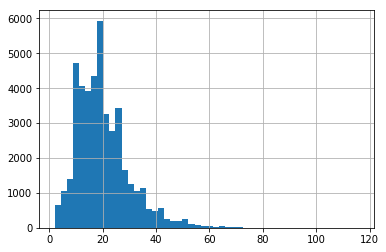

In [30]:
df.name.str.len().hist(bins=50)  # Nice short titles, will try embeddings

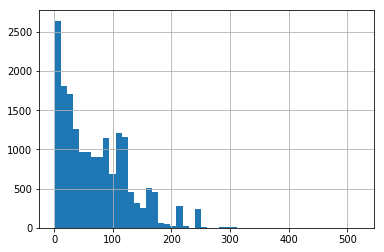

In [7]:
df.description.str.len().hist(bins=50)

In [8]:
df.description[~df.description.isnull()].sample(10)  # Descriptions looks really very various. Does not look like something different than words overlapping will work for them

140634                                                                                   Sweet dessert made of layers of phyllo pastry filled with chopped nuts
116374                                                                                                                                                  Regular
351809                                                                            A strong black tea layered on with zesty ruby grapefruit and a dash of honey.
323727                                                                                                                                                     100g
127674                        Bite-sized apple puffarons filled to the core with pieces of sweet and apple chunks, perfect blend of apple and cinnamon goodness
92580     Why wait until Thanksgiving? Enjoy a Savory Turkey Breast Sub now. Lean and tender, gourmet style sliced turkey breast with your choice of fresh v...
268530                                  

In [9]:
df.sample(20)['name']
# - Clear ids and numbers
# - Clear non-english symbols

337572                                Butter Prawn
465458                       Cappuccino Milk Shake
125603                               TM-30. Pataya
467952                                 Chapati Set
463964                   Wagyu BBQ Bowl (2 Sticks)
100558                         Steak & Cheese Wrap
135215                                     Piccalo
57051                  Multigrain Walnut Sourdough
30107                                       Pearls
300686                          PREM - Cashew Nuts
18989                    SK07 Crispy Prawn Pancake
33573                                  Ice Cendol 
741       13. Liver & Kidney Herbal Soup 砂煲药材猪肝腰子汤
34511           Candied Bacon, Figs and Feta Salad
339766                          Butter Sugar Toast
51205                                  Curry Fish 
408701                     Tissue Prata with Milk 
299542                        Roasted Duck Noodle 
90869                     Musclun + Spinach Leaves
5641                           

## Explore vocab

In [10]:
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [29]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/generall/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [21]:
# Group names by vendor to calculate IDF
# Helps if vendor prefer to name it's items in unique way
vendor_items = df.groupby('vendor_id')['name'].apply(' '.join)

In [22]:
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,1), norm=None, smooth_idf=False)

In [23]:
vectorizer.fit(vendor_items)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_idf=False,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [24]:
idf_df = pd.DataFrame(list(vectorizer.vocabulary_.keys()), columns=['token'])
idf_df['idf'] = idf_df.token.apply(vectorizer.vocabulary_.__getitem__).apply(vectorizer.idf_.__getitem__)

In [25]:
idf_df['pos_tag'] = idf_df.token.apply(lambda x: nltk.pos_tag([x])[0][1])

In [26]:
idf_df.pos_tag.value_counts()

NN      1455
CD       192
NNS      134
JJ        89
VBN       52
RB        24
VBG       15
IN        11
VBD        5
DT         5
PRP        3
CC         3
VB         3
RBR        2
VBZ        2
JJS        2
MD         1
PRP$       1
TO         1
Name: pos_tag, dtype: int64

In [27]:
idf_df.to_csv('./data/vocab.csv', index=None)

### Explore cooking methods

This words might be used as clustering, but it is only applied to a subset of all items

In [28]:
idf_df[idf_df.pos_tag == 'VBN'].sort_values('idf').head(20)

token       idf pos_tag
115      fried  2.415053     VBN
197    roasted  3.191681     VBN
132     salted  3.206719     VBN
111    grilled  3.216872     VBN
199    steamed  3.477706     VBN
324      baked  3.518252     VBN
811    braised  3.674705     VBN
158     minced  3.767598     VBN
681    bottled  3.850595     VBN
482     smoked  3.941109     VBN
161     sliced  4.064169     VBN
152      dried  4.275479     VBN
192   shredded  4.351852     VBN
932  preserved  4.733786     VBN
829     boiled  4.757317     VBN
335     mashed  5.060999     VBN
936   assorted  5.127690     VBN
879  scrambled  5.199149     VBN
697    chilled  5.276110     VBN
980    poached  5.359492     VBN